In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import confusion_matrix

In [4]:
PATH = "data/dogscats/"

In [5]:
sz=224

In [6]:
!ls {PATH}

models	sample	test1  tmp  train  valid


In [7]:
! rm -rf {PATH}tmp

In [8]:
files = !ls {PATH}valid/cats
len(files)


1000

In [9]:
files = !ls {PATH}train/cats | head
files

['cat.0.jpg',
 'cat.10000.jpg',
 'cat.10001.jpg',
 'cat.10002.jpg',
 'cat.10003.jpg',
 'cat.10004.jpg',
 'cat.10005.jpg',
 'cat.10006.jpg',
 'cat.10007.jpg',
 'cat.10008.jpg']

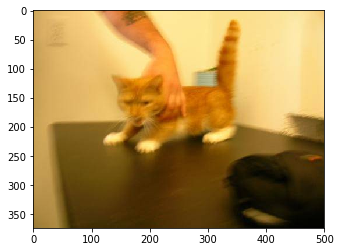

In [10]:
img = plt.imread(f'{PATH}train/cats/{files[0]}')#PATH+'train/cats/'+files[0]
plt.imshow(img)

In [11]:
img.shape

(374, 500, 3)

In [12]:
img[:4,:4]

array([[[203, 164,  87],
        [203, 164,  87],
        [204, 165,  88],
        [206, 167,  90]],

       [[203, 164,  87],
        [203, 164,  87],
        [204, 165,  88],
        [206, 167,  90]],

       [[203, 164,  87],
        [203, 164,  87],
        [204, 165,  88],
        [206, 167,  90]],

       [[203, 164,  87],
        [203, 164,  87],
        [204, 165,  88],
        [206, 167,  90]]], dtype=uint8)

In [13]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms = tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute = True)
learn.fit(0.01, 1)

100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.04516  0.02543  0.99023]                         



In [14]:
# def predict(self, is_test=False): 
#     dl1 = self.data.val_dl
#     preds1,targs = predict_with_targs(self.model, dl1)
#     return preds1,targs
# learn.predict = predict

In [15]:
log_preds  = learn.predict()
log_preds

array([[ -0.00002, -10.61807],
       [ -0.00407,  -5.50686],
       [ -0.00002, -11.0798 ],
       ..., 
       [-14.60166,  -0.     ],
       [ -8.42324,  -0.00022],
       [ -1.05425,  -0.42841]], dtype=float32)

In [16]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1]) 

[[988  12]
 [  8 992]]


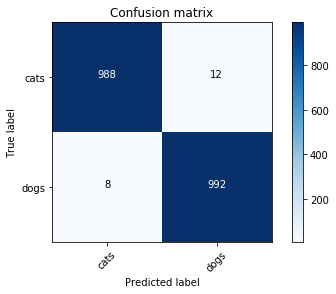

In [17]:
cm = confusion_matrix(data.val_y, preds)
plot_confusion_matrix(cm, data.classes)

In [50]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 10, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [19]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [20]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [21]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [53]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:10]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most incorrect cats


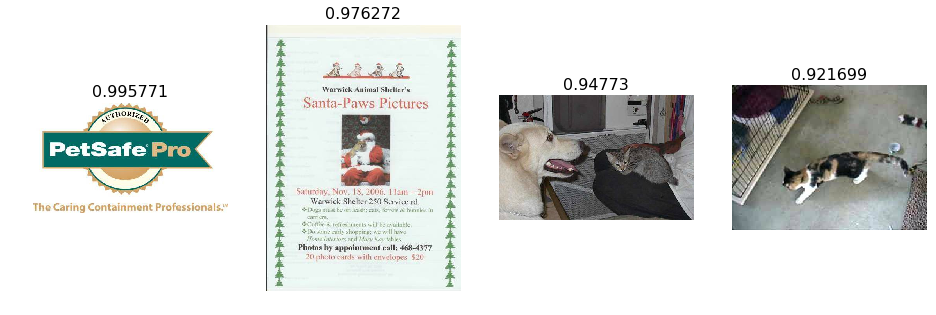

In [23]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


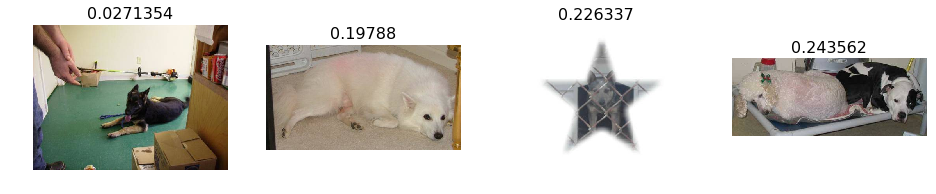

In [24]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


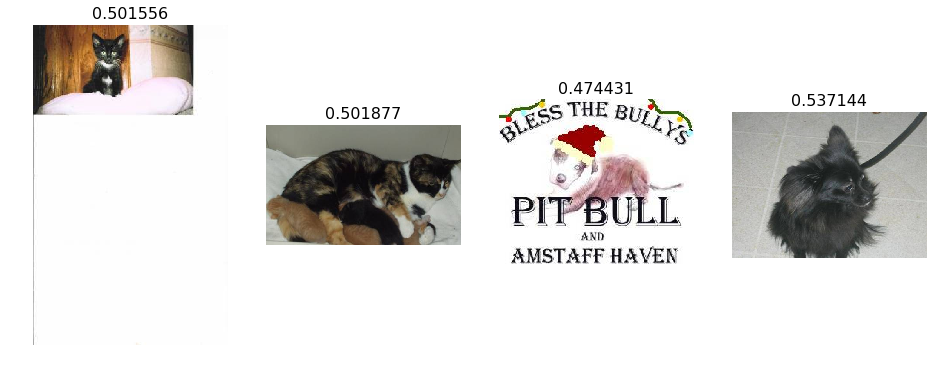

In [25]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [26]:
tfms = tfms_from_model(resnet34, aug_tfms=transforms_side_on, max_zoom=1.1, sz = sz)

In [27]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

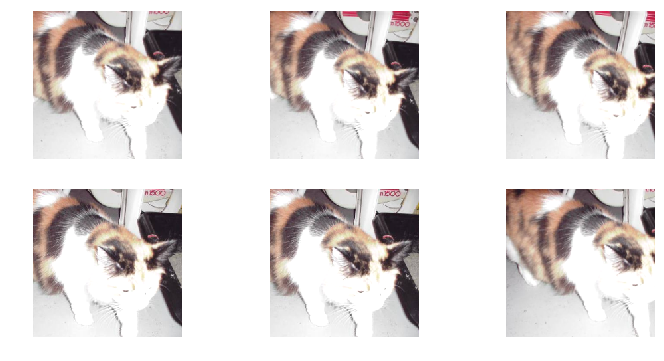

In [28]:
ims = np.stack([get_augs() for i in range(3,9)])
plots(ims, rows=2)

In [29]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [30]:
learn.fit(0.01, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.04252  0.02766  0.99121]                         



In [31]:
learn.precompute=False

In [32]:
learn.fit(0.01, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       0.04832  0.02656  0.98877]                         
[ 1.       0.04449  0.0259   0.98975]                         



In [33]:
log_preds = learn.predict()
log_preds

array([[ -0.00001, -11.98854],
       [ -0.00145,  -6.53607],
       [ -0.00002, -10.60583],
       ..., 
       [-14.48102,  -0.     ],
       [ -7.99965,  -0.00034],
       [ -0.2451 ,  -1.52612]], dtype=float32)

In [34]:
preds = np.argmax(log_preds, axis = 1)
probs = np.exp(log_preds[:,1]) 

[[992   8]
 [ 10 990]]


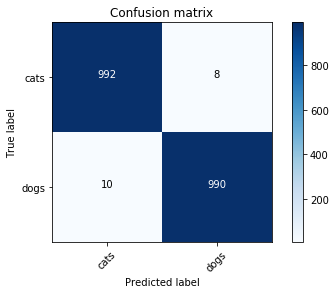

In [35]:
cm = confusion_matrix(data.val_y, preds)
plot_confusion_matrix(cm, data.classes)

Most incorrect cats


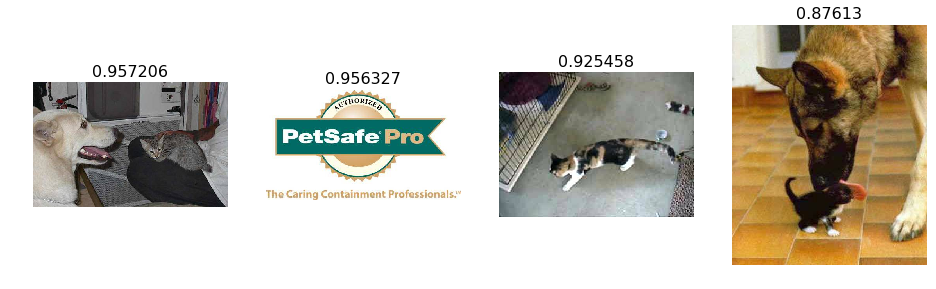

In [36]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


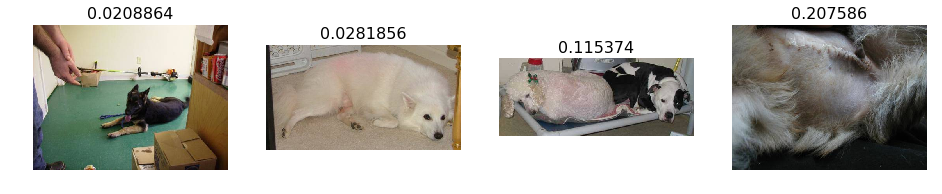

In [37]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

In [38]:
# learn.unfreeze()


In [39]:
# lr=np.array([1e-4,1e-3,1e-2])
# learn.fit(lr, 2, cycle_len=1, cycle_mult=2) 

In [40]:
# log_preds = learn.predict()
# log_preds
# preds = np.argmax(log_preds, axis = 1)
# probs = np.exp(log_preds[:,1]) 

In [41]:
# cm = confusion_matrix(data.val_y, preds)
# plot_confusion_matrix(cm, data.classes)

Most incorrect cats


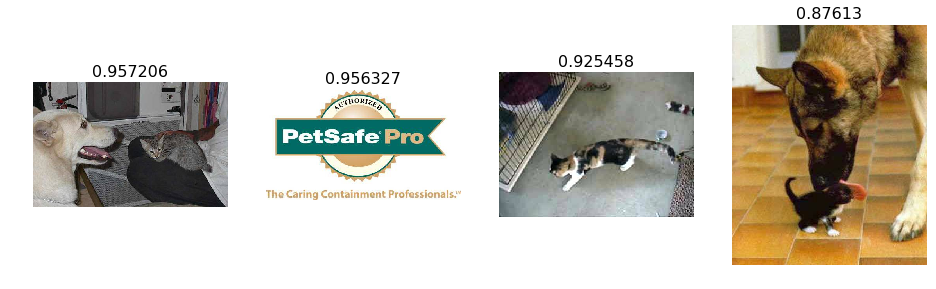

In [42]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


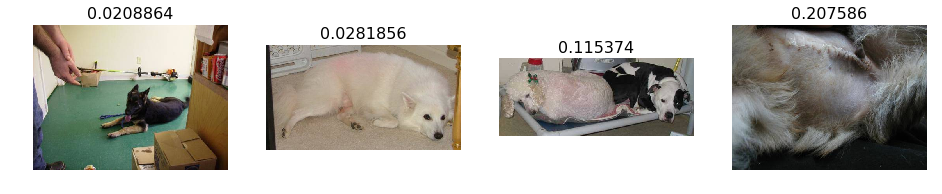

In [43]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

In [44]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [45]:
accuracy(probs, y)

0.99150000000000005

In [46]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

[[991   9]
 [  8 992]]


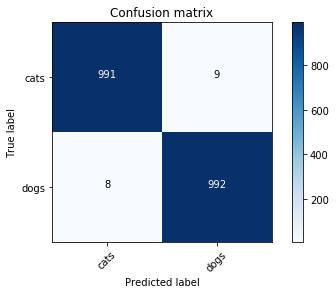

In [47]:
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

Most incorrect cats


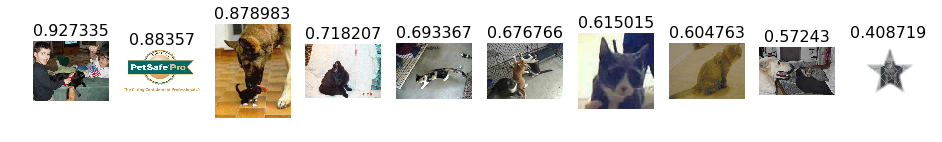

In [54]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


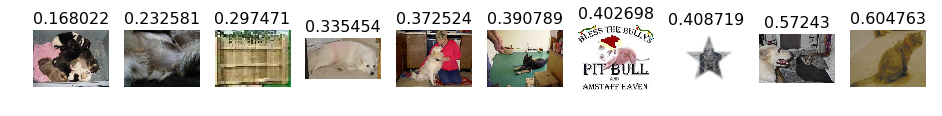

In [55]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")